# **Final Project Task 3 - Census Modeling Regression**

Requirements
- Create a regression model on the Census dataset, with 'hours-per-week' target

- You can use models (estmators) from sklearn, but feel free to use any library for traditional ML. 
    - Note: in sklearn, the LinearRegression estimator is based on OLS, a statistical method. Please use the SGDRegressor estimator, since this is based on gradient descent. 
    - You can use LinearRegression estimator, but only as comparison with the SGDRegressor - Optional.

- Model Selection and Setup **2p**:
    - Implement multiple models, to solve a regression problem using traditional ML: 
        - Linear Regression
        - Decision Tree Regression
        - Random Forest Regression - Optional
        - Ridge Regression - Optional
        - Lasso Regression - Optional
    - Choose a loss (or experiment with different losses) for the model and justify the choice. *1p*
        - MSE, MAE, RMSE, Huber Loss or others
    - Justify model choices based on dataset characteristics and task requirements; specify model pros and cons. *1p*


- Data Preparation
    - Use the preprocessed datasets from Task 1.
    - From the train set, create an extra validation set, if necesarry. So in total there will be: train, validation and test datasets.
    - Be sure all models have their data preprocessed as needed. Some models require different, or no encoding for some features.


- Model Training and Experimentation **10p**
    - Establish a Baseline Model *2p*
        - For each model type, train a simple model with default settings as a baseline.
        - Evaluate its performance to establish a benchmark for comparison.
    - Make plots with train, validation loss and metric on epochs (or on steps), if applicable. - Optional
    - Feature Selection: - Optional
        - Use insights from EDA in Task 2 to identify candidate features by analyzing patterns, relationships, and distributions.
    - Experimentation: *8p*
        - For each baseline model type, iteratively experiment with different combinations of features and transformations.
        - Experiment with feature engineering techniques such as interaction terms, polynomial features, or scaling transformations.
        - Identify the best model which have the best performance metrics on test set.
        - You may need multiple preprocessed datasets preprocessed
- Hyperparameter Tuning - Optional
  - Perform hyperparameter tuning only on the best-performing model after evaluating all model types and experiments. 
  - Consider using techniques like Grid Search for exhaustive tuning, Random Search for quicker exploration, or Bayesian Optimization for an intelligent, efficient search of hyperparameters.
  - Avoid tuning models that do not show strong baseline performance or are unlikely to outperform others based on experimentation.
  - Ensure that hyperparameter tuning is done after completing feature selection, baseline modeling, and experimentation, ensuring that the model is stable and representative of the dataset.


- Model Evaluation **3p**
    - Evaluate models on the test dataset using regression metrics: *1p*
        - Mean Absolute Error (MAE)
        - Mean Squared Error (MSE)
        - Root Mean Squared Error (RMSE)
        - R² Score
    - Choose one metric for model comparison and explain your choice *1p*
    - Compare the results across different models. Save all experiment results  into a table. *1p*

Feature Importance - Optional
- For applicable models (e.g., Decision Tree Regression), analyze feature importance and discuss its relevance to the problem.



Deliverables

- Notebook code with no errors.
- Code and results from experiments. Create a table with all experiments results, include experiment name, metrics results.
- Explain findings, choices, results.
- Potential areas for improvement or further exploration.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from math import sqrt

In [2]:
adult_data_encoded = pd.read_csv("adult_data_encoded")

In [3]:
from sklearn.model_selection import train_test_split

test_data, train_data = train_test_split(adult_data_encoded, test_size=0.2, random_state=42)

print(f"Dimensiune set antrenament: {train_data.shape[0]} rânduri")
print(f"Dimensiune set testare: {test_data.shape[0]} rânduri")

Dimensiune set antrenament: 6144 rânduri
Dimensiune set testare: 24574 rânduri


In [4]:
X_train = train_data.drop('hours_per_week', axis=1) 
Y_train = train_data['hours_per_week']
X_test = test_data.drop('hours_per_week', axis=1) 
Y_test = test_data['hours_per_week']

In [5]:
x_mean_train = X_train.mean()
x_std_train = X_train.std()

y_mean_train = Y_train.mean()
y_std_train = Y_train.std()

In [6]:
# Initializam Modelul
lin_reg = LinearRegression()

# Ajustam modelul pe datele de antrenare
lin_reg.fit(X_train, Y_train)

# Printam coeficientii modelului
print(lin_reg.intercept_, '\n', lin_reg.coef_)

41.77425774175032 
 [-6.45711797e-01 -7.48793205e-01 -2.92655028e-01  5.47577275e+00
  1.61018077e+00 -3.41844462e+00 -1.98034886e+00  6.77743566e-02
  1.12460217e+01 -1.47060282e+00 -1.56311174e+00 -2.66516794e+00
 -9.28038592e-01 -4.68687492e+00 -1.34524376e+00 -6.62145199e-01
 -1.51290914e-01  1.44355911e+00  4.98963000e+00 -9.30237929e-01
  8.49505740e-01 -3.90050007e+00 -3.33647088e+00 -1.42597215e-01
  2.16713178e+00 -6.32578778e-01 -1.62223178e+00  3.27346989e+00
  1.78724815e+00  2.14761369e+00  8.00075782e-01 -5.29363479e+00
  1.69227721e+00 -1.13358004e+00  1.30510713e-01 -2.36391712e-01
  2.88820536e-01  1.86014328e-01 -3.68953865e-01 -1.42691188e+00
  1.42691188e+00 -1.44556882e+00 -2.65175855e+00  1.02014761e+00
 -1.33843926e+00  1.32120254e-01 -3.09404924e-01  1.03859916e+00
  3.69584321e-01  3.36986113e+00 -1.38306955e-02 -1.47798390e+00
 -3.00620588e+00  4.29288560e+00  1.87091105e+00 -5.58990012e+00
  1.99840144e-15 -1.40650039e+01  3.98972037e+00 -2.92381624e+00
  1.2

In [7]:
y_pred_lin = lin_reg.predict(X_test)
y_pred_unnorm_lin = (y_pred_lin * y_std_train) + y_mean_train

In [8]:
sqrt(mean_squared_error(Y_test, y_pred_unnorm_lin))

490.0359176918494

In [9]:
mean_absolute_error(Y_test, y_pred_unnorm_lin)

486.2606998491777

# Am ales ca loss "squared_error" deoarece are cel mai bun rezultat

In [10]:
sgd_reg = SGDRegressor(loss='squared_error')

sgd_reg.fit(X_train, Y_train)

print(sgd_reg.intercept_, '\n', sgd_reg.coef_)

[17.22165354] 
 [ 1.87423088  1.78965974  2.22726494  7.7713918   4.26542377 -0.83778187
 -0.04635329  4.44507372  1.44240717  3.7370843   2.6252039   1.69637608
  3.3309964  -0.2333056  -0.22059511  0.02914443  1.03276983  2.69250351
  5.91350479  0.30020764  2.08509311 -2.66734716 -0.53833092  0.94074586
  2.96522468  0.5808981  -0.52517294  4.45519014  4.20323225  5.29131546
  3.77774322 -2.21214562  4.81832763  1.16536304  2.81527008  3.88956945
  3.76574024  3.19867205  3.37458416  6.95356758 10.09026839  0.27483913
 -0.07738352  0.7464065   0.15480726  0.56966553  0.51558166  0.87496419
  0.36878219  1.25290373  0.49507275  0.05180432 -0.18057593  0.82105448
  0.93086758 -0.59347769  0.         -0.19175793  0.44632816 -0.05298106
  1.17253776  0.82832073  0.40031841  0.53760066 -0.41444665  1.06245997
  0.45884942  2.13035842 -0.13823257 -0.21779746  0.30110995 -1.2597097
  0.4682461   0.08817314  1.385025    0.1179089   2.30017646 -0.04995915
  0.85387458  0.12511017  0.52165887

In [11]:
y_pred_sgd = sgd_reg.predict(X_test)
y_pred_unnorm_sgd = (y_pred_sgd * y_std_train) + y_mean_train

In [12]:
sqrt(mean_squared_error(Y_test, y_pred_unnorm_sgd))

492.51585805457506

In [13]:
mean_absolute_error(Y_test, y_pred_unnorm_sgd)

488.84233132077145

In [14]:
dt_reg = DecisionTreeRegressor(max_depth=5, random_state=42) 
dtree = dt_reg.fit(X_train, Y_train)
y_pred_dt = dt_reg.predict(X_test)

mse_lin = mean_squared_error(Y_test, y_pred_lin)
mse_dt = mean_squared_error(Y_test, y_pred_dt)
mse_sgd = mean_squared_error(Y_test, y_pred_sgd)
mae_lin = mean_absolute_error(Y_test, y_pred_lin)
mae_dt = mean_absolute_error(Y_test, y_pred_dt)
mae_sgd = mean_absolute_error(Y_test,y_pred_sgd)

print(f"MSE Linear Regression: {mse_lin:.2f}")
print(f"MSE Decision Tree: {mse_dt:.2f}")
print(f"MSE SGD: {mse_sgd:.2f}")
print(f"MAE Linear Regression: {mae_lin:.2f}")
print(f"MAE Decision Tree: {mae_dt:.2f}")
print(f"MAE SGD Tree: {mae_sgd:.2f}")

MSE Linear Regression: 118.95
MSE Decision Tree: 117.54
MSE SGD: 118.17
MAE Linear Regression: 7.54
MAE Decision Tree: 7.41
MAE SGD Tree: 7.54


# Putem observa că cel mai bun model în acest caz este Decision Tree, iar SGD-ul este mai bun decat Linear Regression.

In [15]:
import seaborn as sns

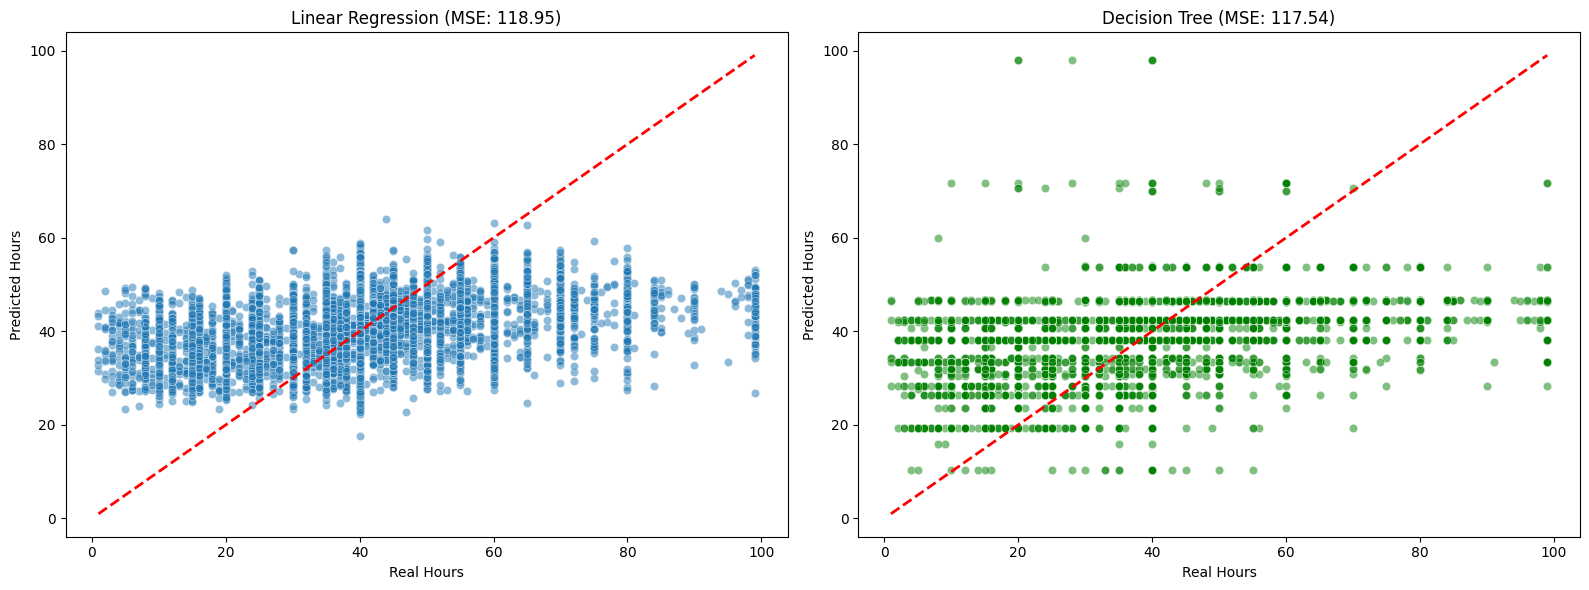

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Grafic Regresie Liniara
sns.scatterplot(x=Y_test, y=y_pred_lin, ax=axes[0], alpha=0.5)
axes[0].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], '--r', lw=2)
axes[0].set_title(f'Linear Regression (MSE: {mse_lin:.2f})')
axes[0].set_xlabel('Real Hours')
axes[0].set_ylabel('Predicted Hours')

# Grafic Decision Tree
sns.scatterplot(x=Y_test, y=y_pred_dt, ax=axes[1], alpha=0.5, color='green')
axes[1].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], '--r', lw=2)
axes[1].set_title(f'Decision Tree (MSE: {mse_dt:.2f})')
axes[1].set_xlabel('Real Hours')
axes[1].set_ylabel('Predicted Hours')

plt.tight_layout()
plt.show()

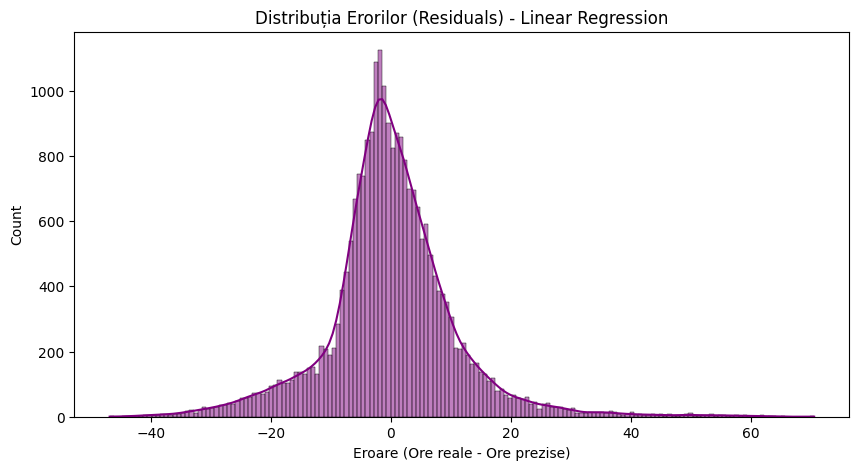

In [17]:
plt.figure(figsize=(10, 5))
residuals = Y_test - y_pred_sgd
sns.histplot(residuals, kde=True, color='purple')
plt.title('Distribuția Erorilor (Residuals) - Linear Regression')
plt.xlabel('Eroare (Ore reale - Ore prezise)')
plt.show()

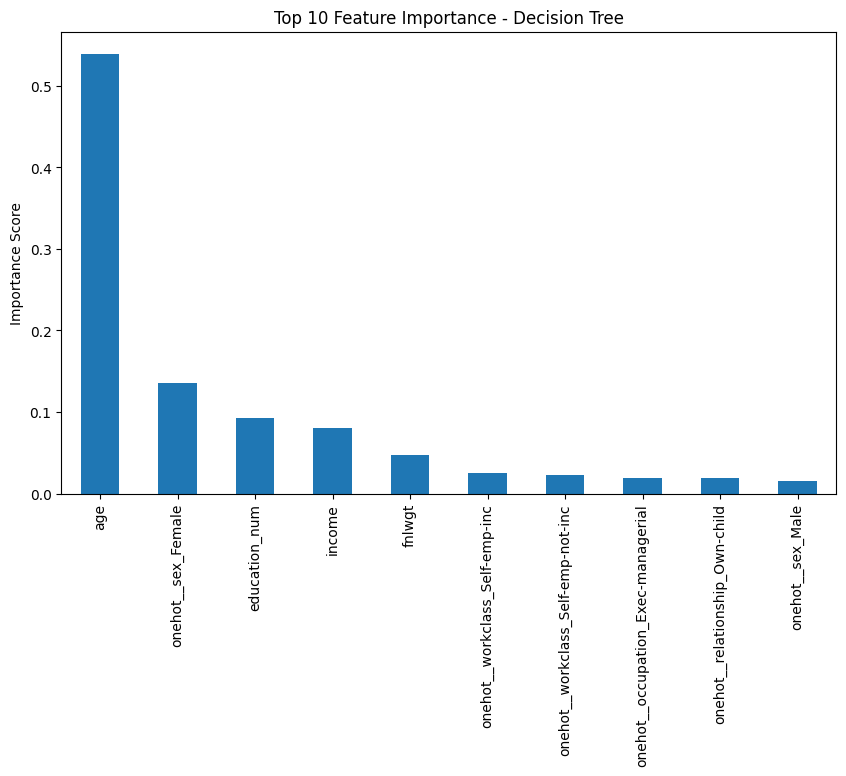

In [18]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor

importances = dt_reg.feature_importances_
feature_names = X_train.columns
tree_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10,6))
tree_importances.head(10).plot(kind='bar')
plt.title('Top 10 Feature Importance - Decision Tree')
plt.ylabel('Importance Score')
plt.show()

# Vedem că cel mai important feature este vârsta, apoi genul, anii de educație, income-ul